# Basic Error Rate

> 5/3/19, 5/10/19, 5/17/19

This document compares the "basic" error rates across different qubits. We will place each qubit into the 0 and 1 states and compare the error in an immediately subsequent measurement. This error rate should be some combination of preparation errors, gate errors (for the 1 state), and measurement error

In [2]:
# snippet: import quantum libraries
from collections import Counter  # useful for tallying results
import qiskit as q
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q.IBMQ.load_accounts()

We will measure the qubits in parallel for both the 0 and 1 cases. We will start with the 0 case.

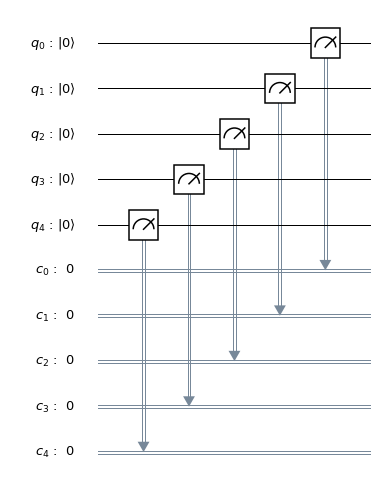

In [3]:
# define registers and circuits
qr = q.QuantumRegister(5, 'q')
cr = q.ClassicalRegister(5, 'c')

circuit_0 = q.QuantumCircuit(qr, cr)
circuit_0.measure(qr, cr)
circuit_0.draw(output='mpl')

In [4]:
# snippet: wrapper to execute some circuit(s)
# this snippet depends on the quantum imports snippet
# parameters:
#   circuit: a single qiskit.QuantumCircuit or a list of them
#   shots, max_credits: self-explanatory
#   qubits: number of qubits needed (only necessary for auto-backend)
#   backend: either None (auto-choose leasy busy) or qiskit.IBMQBackend
#   opt: make circuit optimizations
# returns:
#   job: the job that ran
#   backend: the backend used
#   circuit: the circuit(s) used (for reproducibility)
def run(circuit, shots=1024, max_credits=10, qubits=5, backend=None, opt=True):

    if backend is None:
        # get least busy backend if not specified
        available = q.IBMQ.backends(filters=lambda x:
                                    x.configuration().n_qubits >= qubits
                                    and not
                                    x.configuration().simulator)
        backend = q.providers.ibmq.least_busy(available)

    manager = None
    if not opt:
        # disable optimization by adding a dummy pass manager
        manager = q.tools.compiler.PassManager()

    # execute job
    job = q.execute(circuit, backend=backend, shots=shots,
                    max_credits=max_credits, pass_manager=manager)
    monitor.job_monitor(job)

    # print job info for later retrieval if necessary
    print('Job ID \'%s\'' % job.job_id())
    print('Ran on backend \'%s\'' % backend.name())
    print('Completed %s' % job.creation_date())

    return job, backend, circuit

In [30]:
job_0, backend_0, _ = run(circuit_0)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdeca8e1f8c620079a87372'
Ran on backend 'ibmqx4'
Completed 2019-05-17T14:51:58.443Z


Next, we will try the 1 case.

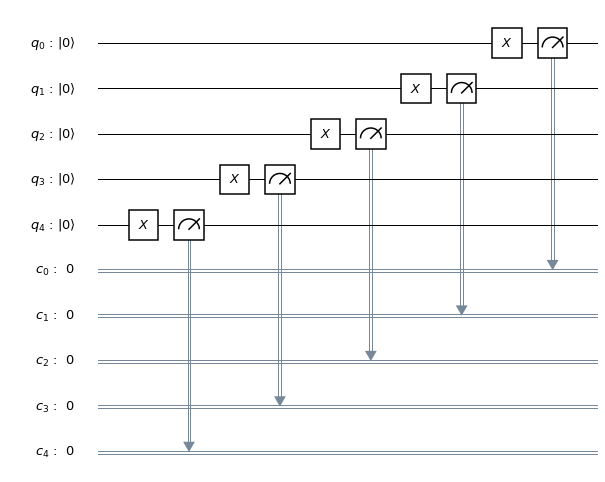

In [5]:
circuit_1 = q.QuantumCircuit(qr, cr)
circuit_1.x(qr)
circuit_1.measure(qr, cr)
circuit_1.draw(output='mpl')

In [32]:
# run with same backend for consistency
ibm = q.IBMQ.get_backend('ibmqx4')
job_1, backend_1, _ = run(circuit_1, backend=ibm)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdecbbaefd27b006f4f0887'
Ran on backend 'ibmqx4'
Completed 2019-05-17T14:56:58.330Z


Now we can make some pretty plots.

In [6]:
# snippet: retrieve an old qiskit job from job id and backend name
def get_job(job_id, backend_name):
    backend = q.IBMQ.get_backend(backend_name)
    return backend.retrieve_job(job_id)

In [33]:
job_0 = get_job('5cdeca8e1f8c620079a87372', 'ibmqx4')
job_1 = get_job('5cdecbbaefd27b006f4f0887', 'ibmqx4')

data_0 = job_0.result().get_counts(0)
data_1 = job_1.result().get_counts(0)

In [22]:
# analyze a trial and return the results as a tuple
def count_results(result, circuit, bit, shots=1024):
    freq   = [0, 0, 0, 0, 0]
    stderr = [0, 0, 0, 0, 0]

    for i in range(len(freq)):
        for state, count in result.items():
            if state[-i-1] == bit:
                freq[i] += count
        freq[i] /= shots
        stderr[i] = np.sqrt(freq[i] * (1 - freq[i]) / shots)    

    return freq, stderr

[0.9931640625, 0.9931640625, 0.9814453125, 0.67578125, 0.7529296875]
[0.8994140625, 0.8642578125, 0.9326171875, 0.6474609375, 0.7568359375]


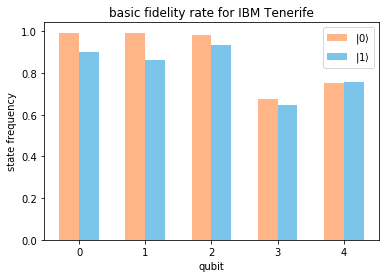

In [45]:
# plot fancy barplot
p0, s0 = count_results(data_0, circuit_0, '0')
p1, s1 = count_results(data_1, circuit_1, '1')
print(p0)
print(p1)

fig, ax = plt.subplots()
width = 0.3
qubits = np.arange(5)

ax.bar(qubits - width/2, p0, width, color='#ffb587', label=r'$\vert 0 \rangle$')
ax.bar(qubits + width/2, p1, width, color='#7cc5ea', label=r'$\vert 1 \rangle$')
ax.set_title('basic fidelity rate for IBM Tenerife')
ax.set_ylabel('state frequency')
ax.set_xlabel('qubit')
ax.legend()

This is a pretty reasonable graph; the values are all a little less than one, and the blue bars are generally less than the orange bars, since the NOT gate should introduce some error. For comparison, let's see the current official calibration values for the Tenerife device:

In [61]:
def get_readout_err(nduvs):
    nduv = filter(lambda n: n.name == 'readout_error', nduvs)
    return round(list(nduv)[0].value, 5)

# NOT gates are implemented as u3(pi, 0, pi)
def get_u3_err(gates):
    u3s = filter(lambda g: g.gate == 'u3', gates)
    val = map(lambda g: g.parameters[0].value, u3s)
    return list(map(lambda x: round(x, 6), val))

backend = q.IBMQ.get_backend('ibmqx4')
print(list(map(get_readout_err, backend.properties().qubits)))
print(get_u3_err(backend.properties().gates))

[0.05475, 0.066, 0.028, 0.33125, 0.2345]
[0.001545, 0.002919, 0.003091, 0.002404, 0.004293]


Or, in a more pretty table:

| Error Type | Q<sub>0</sub> | Q<sub>1</sub> | Q<sub>2</sub> | Q<sub>3</sub> | Q<sub>4</sub> |
|---|---|---|---|---|---|
| U3 Gate, *p<sub>G</sub>* (10<sup>-3</sup>) | 1.545 | 2.919 | 3.091 | 2.404 | 4.293 |
| Readout, *p<sub>R</sub>* (10<sup>-2</sup>) | 5.475 | 6.600 | 2.800 | 33.125 | 23.450 |


Actually, we can do some statistics on what we would expect to measure based on the current IBM calibration values. We can do z-test to see if the frequency of 0 or 1 measurement is what we'd expect.

We can compute the expected frequencies from the posted errors. For the immediate measurement (no intermediate gate) case, we'd expect the frequency of 0's to be $1 - p_R$. For a sample size of 1024, we can test the hypotheses:

$$H_0: \hat{p} = 1 - p_R \\ H_A: \hat{p} \ne 1 - p_R$$

In [62]:
from scipy.stats import norm

# do a two-tailed z-test for each qubit:
def z_test(props, n=1024):
    p_hat, p_hyp = props
    stderr = np.sqrt(p_hyp * (1 - p_hyp) / n)
    
    z = (p_hat - p_hyp) / stderr
    p_val = 2 * (1 - norm.cdf(abs(z)))
    return p_hat, p_hyp, z, p_val

# these are sensitive to the time the experiment was run
# so we store them here instead of re-generating
readout_err = [0.05475, 0.066, 0.028, 0.33125, 0.2345]
list(map(z_test, zip(p0, map(lambda x: 1 - x, readout_err))))

[(0.9931640625, 0.94525, 6.7398086800512935, 1.585953590677036e-11),
 (0.9931640625, 0.9339999999999999, 7.625398762644407, 2.4424906541753444e-14),
 (0.9814453125, 0.972, 1.8321210367730234, 0.06693338983246266),
 (0.67578125, 0.66875, 0.4780492895703197, 0.6326151237686379),
 (0.7529296875, 0.7655000000000001, -0.9494061305285582, 0.3424140935720894)]

We get the results:

| Statistic | Q<sub>0</sub> | Q<sub>1</sub> | Q<sub>2</sub> | Q<sub>3</sub> | Q<sub>4</sub> |
|---|---|---|---|---|---|
| Observed Freq. | 0.993 | 0.993 | 0.981 | 0.676 | 0.753 |
| Expected Freq. | 0.945 | 0.934 | 0.972 | 0.669 | 0.766 |
| z-score | +6.7398 | +7.6254 | +1.8321 | +0.4780 | -0.9494 |
| p-value | 1.5&times;10<sup>-11</sup> | 2.4&times;10<sup>-14</sup> | 0.0669 | 0.6326 | 0.3424 |

In most cases, the difference between the observed and expected result is not statistically significant. However, for q<sub>0</sub> and q<sub>1</sub>, the results are very different. Why is this? One thing that comes to mind is that not all qubits are actually measured instantaneously; i.e. there is some delay before measuring some of them. However, energy relaxation shouldn't really affect the $\vert 0 \rangle$ state, and moreover, that should lower the observed frequencies, not increase them. The other things that come to mind are random bitflips and state preparation errors.

Let us attempt to quantify some overall fidelity rate $s$, the probability that a given qubit is actually in the $\vert 0 \rangle$ state when it is measured. This should encapsulate any random, independent error that can happen to it between preparation and measurement. Then the expected frequency $p_0$ of measuring a $0$ for any qubit, as a function of the state fidelity $s$ and the readout error $p_R$, is:

$$p_0 = (1 - p_R) s + p_R (1 - s) = s + p_R - 2sp_R$$

Since we naturally have $0 \le s \le 1$, we require that:

$$p_R \le p_0 \le 1 - p_R$$

We now wish to determine if such an error described by a state fidelity $s$ could possibly account for the discrepancy in our experimental results. We will make the assumption that each trial is independent and that the sampling distribution is normally distributed, which is probably a pretty good assumption due to the central limit theorem of statistics. At some confidence level $\alpha$, we wish to see if there is a reasonable $s$ that leads to a $p_0$ for which $\hat{p}$ (the observed/experimental frequency of $0$'s) lies outside the rejection region. That is, we wish to find a reasonable value:

$$s = \frac{p_0 - p_R}{1 - 2 p_R}$$

such that:

$$\left\vert \frac{\hat{p} - p_0}{\sqrt{\frac{p_0 (1 - p_0)}{n}}} \right\vert \le C(\alpha) $$

where $C$ is the standard normal percent point function, or $C(\alpha) = \mathrm{\texttt{norm.ppf}}(1 - \alpha / 2)$, to use `scipy` terminology. For reasonable values of $p_R$, this constraint can be written in the form:

$$(A+1)p_0^2 - (A-2\hat{p})p_0 + \hat{p}^2 \le 0$$

where $A(\alpha, n) = C(\alpha)^2 / n$ for brevity. This is an upward-facing parabola; $p_0$ must thus lie between its roots, giving an additional constraint on $p_0$. Now we see an issue: the two sets of constraints on $p_0$, when computed for q<sub>0</sub> and q<sub>1</sub>, are conflicting:

In [98]:
import scipy.optimize as opt

def compute_max_s(props, n=1024, alpha=0.05):
    phat, p_R = props
    
    A = norm.ppf(1 - alpha / 2) ** 2 / n  # rejection region
    B = A + 2 * phat
    D = 2 * (A + 1)
    C = np.sqrt(B ** 2 - 2 * D * phat ** 2)
    
    lo = max((B - C) / D, p_R)
    hi = min((B + C) / D, 1 - p_R)
    print('constraint: %f < p0 < %f' % (lo, hi))
    return lo < hi  # constraint feasibility
    
    # we can't actually do the optimization, since the bounds are bad
    # s = lambda x: (x - p_R) / (1 - 2 * p_R)  # s(p_0)
    # p_0 = opt.minimize_scalar(lambda x: -s(x), bounds=(lo, hi), method='bounded').x
    # return s(p_0)

list(map(compute_max_s, zip(p0, readout_err)))

constraint: 0.985957 < p0 < 0.945250
constraint: 0.985957 < p0 < 0.934000
constraint: 0.971202 < p0 < 0.972000
constraint: 0.646501 < p0 < 0.668750
constraint: 0.725600 < p0 < 0.765500


[False, False, True, True, True]

That is, unless I've done my math wrong (which is honestly probably a pretty reasonable assumption), there is no way this discrepancy between experimental results and expected results can be due to some random, independent bit erorr described by $s$. (This can be intuitively thought of as the readout fidelity being so high for these gates that any state error will only make the expected frequency worse.) So there are a few things that could be wrong here: either there is some error in the above computations, there is an error in the experimental setup, there is some deeper, non-independent, non-random correlation between trials, or there is an error that I haven't thought of yet. This is slightly depressing, so I'm going to do something else now and come back to this later with a "fresh perspective."

Actually, come think of it, there was also the unspoken assumption that the readout error was independent of the state error, but that seems pretty solid. (Granted, when you're dealing with spooky quantum effects, I suppose independence should not be taken for granted.)

One thing that we might be able to do is to use the Ignis noise reduction stuff first and then attempt to measure the basic error rates again. Maybe I'll work on that next week.

The rest of the stuff in this notebook can be considered "scrapwork" that I'm going to save in case it is useful later.

---

In [93]:
def test_s(s, p_obs, p_readout):
    p_exp = s + p_readout - 2 * s * p_readout
    p_hat, p_hyp, z, p_val = z_test((p_obs, p_exp))
    print('the state fidelity is %f' % s)
    print('the expected 0 rate is %f' % p_hyp)
    print('the observed 0 rate is %f' % p_hat)
    print('this is a z-score of %f' % z)
    print('this is a p-value of %f' % p_val)

test_s(1.046, p0[0], readout_err[0])

the state fidelity is 1.046000
the expected 0 rate is 0.986213
the observed 0 rate is 0.993164
this is a z-score of 1.907572
this is a p-value of 0.056447

the state fidelity is 0.980000
the expected 0 rate is 0.754880
the observed 0 rate is 0.752930
this is a z-score of -0.145086
this is a p-value of 0.884643


We verify that the sample is sufficiently large for a z-test to be feasible:

In [100]:
list(map(lambda x: x * 1024, readout_err))

[56.064, 67.584, 28.672, 339.2, 240.128]

Let's see if a &chi;<sup>2</sup> test for goodness of fit gives any different results:

In [107]:
from scipy.stats import chi2

def chi_sq_test(props, n=1024):
    # observed and expected counts
    obs, exp = map(lambda p: p * n, props)
    obsv = [obs, n - obs]
    expv= [n - exp, exp]
    
    # component list
    comp = map(lambda x: (x[0] - x[1]) ** 2 / x[1], zip(obsv, expv))
    
    chi_sq = sum(comp)
    p_val = 1 - chi2.cdf(chi_sq, 1)
    return chi_sq, p_val

list(map(chi_sq_test, zip(p0, readout_err)))

[(45.4250210436948, 1.585953590677036e-11),
 (58.1467062893388, 2.4313884239290928e-14),
 (3.356667493386244, 0.06693338983246366),
 (0.22853112325868502, 0.6326151237686397),
 (0.9013720006852033, 0.34241409357209107)]

And...the &chi;<sup>2</sup> test gives exactly the same thing:

| Statistic | Q<sub>0</sub> | Q<sub>1</sub> | Q<sub>2</sub> | Q<sub>3</sub> | Q<sub>4</sub> |
|---|---|---|---|---|---|
| Observed Freq. | 0.993 | 0.993 | 0.981 | 0.676 | 0.753 |
| Expected Freq. | 0.945 | 0.934 | 0.972 | 0.669 | 0.766 |
| Sample Size | 1024 | 1024 | 1024 | 1024 | 1024 |
| &chi;<sup>2</sup> | 45.425 | 58.147 | 3.357 | 0.229 | 0.901 |
| p-value | 1.6&times;10<sup>-11</sup> | 2.4&times;10<sup>-14</sup> | 0.0669 | 0.6326 | 0.3424 |